In [78]:
#HyperParameters

input_dim = 1 #입력하는 feature 개수
#time_interval = 8 #minute. n분 마다 n분 누적 신호 발생. 혹은 lstm cell에서 시계열의 갯수
min_transaction_amount = 5000000 # 100만원 미만이면 리시버에서 버퍼로 데이터 안보내게끔.
n_cell = 32 # LSTM셀의 개수
n_labels = 4 #모델의 결과 값 라벨 수 e.g. n=4, 라벨이 강하락, 약하락, 약상승, 강상승 신호 발생.
seq_length = 60 # 모델이 참고 할 이전 분봉의 개수. LSTM/RNN에서
lr = 0.003 # 학습률
keep_prob = 1.0 #dropout rate
n_stacked_layers = 1 # 모델의 레이어 개수
n_epochs = 3 # 학습횟수. 얼리스타핑 넣을까말까
n_batch_size = 32 #학습 배치 사이즈
model_path = None

In [85]:
data1

time  price  amount  state     feature      1분후     label
0     2020-06-04 09:03:34  91200   91200     -1 -8317440000  91000.0  0.997807
1     2020-06-04 09:03:34  91200   91100     -1 -8308320000  91000.0  0.997807
2     2020-06-04 09:03:34  91200   91200     -1 -8317440000  91000.0  0.997807
3     2020-06-04 09:03:34  91200   91100     -1 -8308320000  91000.0  0.997807
4     2020-06-04 09:03:34  91200   91200     -1 -8317440000  91000.0  0.997807
...                   ...    ...     ...    ...         ...      ...       ...
66576 2020-06-04 15:19:22  87800   87700     -1 -7700060000      NaN       NaN
66577 2020-06-04 15:19:22  87800   87800     -1 -7708840000      NaN       NaN
66578 2020-06-04 15:19:22  87800   87700     -1 -7700060000      NaN       NaN
66579 2020-06-04 15:19:22  87800   87800     -1 -7708840000      NaN       NaN
66580 2020-06-04 15:19:23  87800   87800     -1 -7708840000      NaN       NaN

[66581 rows x 7 columns]

In [87]:
data1[data1['state']==1]

Empty DataFrame
Columns: [time, price, amount, state, feature, 1분후, label]
Index: []

In [94]:
import pandas as pd
import datetime
import numpy as np
import math
#import openpyxl
#import os
time_lst=[]
price_lst=[] #체결가
temp_lst=[] # 1: 매수 2:매도
amount_lst=[] #체결수량
state_lst=[]
feature_lst=[]
after_price_lst=[]
rate_lst=[]
label_lst=[]
def func1():
    file_name="20200604000660.txt"
    in_file=open(file_name,"r") #file open

    in_str=in_file.read() #file read
    lst=in_str.split(')') # split
    new_lst=[]
    for el in lst :
        new_lst.append(el.lstrip(', ('))
    new_lst=list(filter(None,new_lst))
    #########################################리스트에 생성##################3
    time_lst=[]
    for el in new_lst:
        lst2 = el.split(',')
        
        #time=datetime.datetime.strptime(lst2[1].lstrip("' ").rstrip("' "),'%H%M%S')
        time = lst2[1].lstrip("' ").rstrip("' ")
        if(len(time)<14):
            time=time[:8]+'0'+time[8:13]
        time = datetime.datetime.strptime(time,"%Y%m%d%H%M%S")
        time_lst.append(time)  # 시간리스트에 추가
        price_lst.append(int(lst2[2]))  # 체결가 리스트에 추가
        amount_lst.append(int(lst2[8]))

        temp=lst2[6].lstrip(" '").rstrip(" '")
        state=int(temp)
        
        if(state=="1") :
            state_lst.append(1)
        else:
            state_lst.append(-1)
    print(len(time_lst),len(price_lst),len(state_lst),len(amount_lst))
    time_lst = pd.to_datetime(time_lst)
    raw_data = {'time': time_lst, 'price': price_lst,'amount':amount_lst,'state':state_lst}
    data = pd.DataFrame(raw_data)

    in_file.close()
    return data
data1=func1()
#############체결가 X 체결량 X 상태 (피처값)열, 1분후 열 추가########################################
for i in range(len(data1)) :
    feature=data1.loc[i]['price'] *data1.loc[i]['amount'] * data1.loc[i]['state']
    #print(feature)
    feature_lst.append(feature)

    is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1)  # 각 행에대해서 1분 후의 가격이 존재하면 리스트에 추가
    temp = data1[is_time].reset_index(drop=True)
    if (temp.empty == False):
        after_price_lst.append(temp.loc[0]['price'])
    else:  # 1분후 값이 존재하지 않는 부분 1분 5초후 or  nan으로 채움
        is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1, seconds=5)
        temp = data1[is_time].reset_index(drop=True)
        if (temp.empty == False):
            after_price_lst.append(temp.loc[0]['price'])
        else:
            after_price_lst.append(np.nan)

data1['feature']=feature_lst
data1['1분후'] = after_price_lst
#############상승률 (label)열 추가########################################
for i in range(len(data1)):
    if(data1.loc[i]['1분후']!=np.nan) :
        rate=data1.loc[i]['1분후']/data1.loc[i]['price']
    else :
        rate=np.nan
    rate_lst.append(rate)
data1['label']=rate_lst

#print(data1.head(10))
###################################################임계치 넘는 값,  결측치 아닌값에 대해서만 train set을 df에저장
df=data1[abs(data1['feature'])>=min_transaction_amount]
df=df.dropna()
#print(df.head(20))


X_list=df.feature.tolist()
label_list=df.label.tolist()
#print(len(X_list),len(label_list))

#################feature 값 3차원 array로 데이터 변환################

sample_num=0
feature_lst_3dim=[]
for i in range(len(X_list)-seq_length+1) :
        temp=X_list[i:i+seq_length] # temp는 1차원 list
        arr=np.array([temp]).T # arr는 temp를 배열로 변환후 transpose
        arr=arr.tolist() # 다시 리스트로 바꾸어
        feature_lst_3dim.append(arr) #최종 리스트에 추가
        sample_num=sample_num+1
print("데이터 샘플의 갯수: ",sample_num)
print("시계열의 크기 : ",seq_length)
X_arr=np.array(feature_lst_3dim) # list를 3차원 array로 변환
print(X_arr.shape)
#X_arr = feature 가 저장된 3차원 array
#################label 값 3차원 array로 데이터 변환################
label_len=0
label_lst_2dim=[]
for i in range(seq_length-1,len(label_list),1):
    temp=[]
    temp.append(label_list[i])
    label_lst_2dim.append(temp)
    label_len=label_len+1
Y_arr=np.array(label_lst_2dim)
print("라벨의 갯수: ",label_len)
print(Y_arr.shape)
#print(Y_arr)
# Y_arr = label이 저장된 3차원 array

"""print(data1.head(10))
base_dir="C:/Users/82107/PycharmProjects/DartProject"
file_nm="PreprocessingData.xlsx"
xlsx_dir=os.path.join(base_dir,file_nm)

data1.to_excel(xlsx_dir)
"""

["'000660'", " '2020060490334'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 1', ' 518222', ' 150612', ' 367163', ' 4692005', " '2'"]
["'000660'", " '2020060490334'", ' 91200', ' 91100', ' 91100', " '2'", " '2'", " '-'", ' 909', ' 519131', ' 151521', ' 367163', ' 4700286', " '2'"]
["'000660'", " '2020060490334'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 1', ' 519132', ' 151521', ' 367164', ' 4700295', " '2'"]
["'000660'", " '2020060490334'", ' 91200', ' 91100', ' 91100', " '2'", " '2'", " '-'", ' 16', ' 519148', ' 151537', ' 367164', ' 4700441', " '2'"]
["'000660'", " '2020060490334'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 10', ' 519158', ' 151537', ' 367174', ' 4700532', " '2'"]
["'000660'", " '2020060490334'", ' 91200', ' 91100', ' 91100', " '2'", " '2'", " '-'", ' 35', ' 519193', ' 151572', ' 367174', ' 4700851', " '2'"]
["'000660'", " '2020060490334'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 7', ' 519200', ' 151572', ' 36

["'000660'", " '2020060490723'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 15', ' 811193', ' 296014', ' 514732', ' 7356599', " '2'"]
["'000660'", " '2020060490723'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 1', ' 811194', ' 296014', ' 514733', ' 7356609', " '2'"]
["'000660'", " '2020060490723'", ' 91200', ' 91100', ' 91100', " '2'", " '2'", " '-'", ' 1', ' 811195', ' 296015', ' 514733', ' 7356618', " '2'"]
["'000660'", " '2020060490724'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 4', ' 811199', ' 296015', ' 514737', ' 7356654', " '2'"]
["'000660'", " '2020060490724'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 20', ' 811219', ' 296015', ' 514757', ' 7356837', " '2'"]
["'000660'", " '2020060490724'", ' 91200', ' 91100', ' 91100', " '2'", " '2'", " '-'", ' 4', ' 811223', ' 296019', ' 514757', ' 7356873', " '2'"]
["'000660'", " '2020060490724'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 12', ' 811235', ' 296019', ' 5147

["'000660'", " '2020060491133'", ' 91300', ' 91200', ' 91200', " '2'", " '1'", " '+'", ' 104', ' 1109528', ' 436210', ' 672871', ' 10082626', " '2'"]
["'000660'", " '2020060491133'", ' 91300', ' 91200', ' 91200', " '2'", " '1'", " '+'", ' 20', ' 1109548', ' 436210', ' 672891', ' 10082808', " '2'"]
["'000660'", " '2020060491133'", ' 91300', ' 91200', ' 91200', " '2'", " '1'", " '+'", ' 1', ' 1109549', ' 436210', ' 672892', ' 10082817', " '2'"]
["'000660'", " '2020060491133'", ' 91300', ' 91200', ' 91200', " '2'", " '1'", " '+'", ' 10', ' 1109559', ' 436210', ' 672902', ' 10082908', " '2'"]
["'000660'", " '2020060491133'", ' 91300', ' 91200', ' 91200', " '2'", " '1'", " '+'", ' 10', ' 1109569', ' 436210', ' 672912', ' 10083000', " '2'"]
["'000660'", " '2020060491134'", ' 91200', ' 91100', ' 91100', " '2'", " '2'", " '-'", ' 1', ' 1109570', ' 436211', ' 672912', ' 10083009', " '2'"]
["'000660'", " '2020060491134'", ' 91200', ' 91100', ' 91200', " '1'", " '1'", " '+'", ' 31', ' 1109601', '

["'000660'", " '2020060491618'", ' 90200', ' 90100', ' 90100', " '2'", " '2'", " '-'", ' 10', ' 1414543', ' 632933', ' 781163', ' 12849907', " '2'"]
["'000660'", " '2020060491618'", ' 90200', ' 90100', ' 90100', " '2'", " '2'", " '-'", ' 74', ' 1414617', ' 633007', ' 781163', ' 12850573', " '2'"]
["'000660'", " '2020060491618'", ' 90200', ' 90100', ' 90100', " '2'", " '2'", " '-'", ' 100', ' 1414717', ' 633107', ' 781163', ' 12851474', " '2'"]
["'000660'", " '2020060491618'", ' 90200', ' 90100', ' 90100', " '2'", " '2'", " '-'", ' 250', ' 1414967', ' 633357', ' 781163', ' 12853727', " '2'"]
["'000660'", " '2020060491618'", ' 90200', ' 90100', ' 90100', " '2'", " '2'", " '-'", ' 5', ' 1414972', ' 633362', ' 781163', ' 12853772', " '2'"]
["'000660'", " '2020060491619'", ' 90200', ' 90100', ' 90100', " '2'", " '2'", " '-'", ' 800', ' 1415772', ' 634162', ' 781163', ' 12860980', " '2'"]
["'000660'", " '2020060491619'", ' 90200', ' 90100', ' 90100', " '2'", " '2'", " '-'", ' 16', ' 1415788'

["'000660'", " '2020060492009'", ' 89600', ' 89500', ' 89500', " '2'", " '2'", " '-'", ' 250', ' 1693904', ' 825851', ' 867606', ' 15357868', " '2'"]
["'000660'", " '2020060492009'", ' 89600', ' 89500', ' 89500', " '2'", " '2'", " '-'", ' 168', ' 1694072', ' 826019', ' 867606', ' 15359372', " '2'"]
["'000660'", " '2020060492009'", ' 89600', ' 89500', ' 89500', " '2'", " '2'", " '-'", ' 278', ' 1694350', ' 826297', ' 867606', ' 15361860', " '2'"]
["'000660'", " '2020060492009'", ' 89600', ' 89500', ' 89500', " '2'", " '1'", " '+'", ' 1', ' 1694351', ' 826297', ' 867607', ' 15361869', " '2'"]
["'000660'", " '2020060492009'", ' 89600', ' 89500', ' 89500', " '2'", " '1'", " '+'", ' 2', ' 1694353', ' 826297', ' 867609', ' 15361887', " '2'"]
["'000660'", " '2020060492009'", ' 89600', ' 89500', ' 89500', " '2'", " '1'", " '+'", ' 1', ' 1694354', ' 826297', ' 867610', ' 15361896', " '2'"]
["'000660'", " '2020060492009'", ' 89600', ' 89500', ' 89400', " '2'", " '2'", " '-'", ' 16', ' 1694370', 

["'000660'", " '2020060492359'", ' 89700', ' 89600', ' 89600', " '2'", " '2'", " '-'", ' 50', ' 1957837', ' 964791', ' 992599', ' 17713644', " '2'"]
["'000660'", " '2020060492400'", ' 89700', ' 89600', ' 89700', " '1'", " '1'", " '+'", ' 6', ' 1957843', ' 964791', ' 992605', ' 17713698', " '2'"]
["'000660'", " '2020060492400'", ' 89700', ' 89600', ' 89700', " '1'", " '1'", " '+'", ' 6', ' 1957849', ' 964791', ' 992611', ' 17713752', " '2'"]
["'000660'", " '2020060492400'", ' 89700', ' 89600', ' 89700', " '1'", " '1'", " '+'", ' 20', ' 1957869', ' 964791', ' 992631', ' 17713931', " '2'"]
["'000660'", " '2020060492400'", ' 89700', ' 89600', ' 89700', " '1'", " '1'", " '+'", ' 15', ' 1957884', ' 964791', ' 992646', ' 17714066', " '2'"]
["'000660'", " '2020060492400'", ' 89700', ' 89600', ' 89700', " '1'", " '1'", " '+'", ' 7', ' 1957891', ' 964791', ' 992653', ' 17714129', " '2'"]
["'000660'", " '2020060492400'", ' 89700', ' 89600', ' 89700', " '1'", " '1'", " '+'", ' 7', ' 1957898', ' 96

["'000660'", " '2020060493052'", ' 89500', ' 89400', ' 89400', " '2'", " '2'", " '-'", ' 34', ' 2149183', ' 1066266', ' 1082470', ' 19424258', " '2'"]
["'000660'", " '2020060493052'", ' 89500', ' 89400', ' 89400', " '2'", " '2'", " '-'", ' 211', ' 2149394', ' 1066477', ' 1082470', ' 19426144', " '2'"]
["'000660'", " '2020060493052'", ' 89500', ' 89400', ' 89500', " '1'", " '1'", " '+'", ' 503', ' 2149897', ' 1066477', ' 1082973', ' 19430646', " '2'"]
["'000660'", " '2020060493053'", ' 89500', ' 89400', ' 89500', " '1'", " '1'", " '+'", ' 1', ' 2149898', ' 1066477', ' 1082974', ' 19430655', " '2'"]
["'000660'", " '2020060493053'", ' 89500', ' 89400', ' 89500', " '1'", " '1'", " '+'", ' 10', ' 2149908', ' 1066477', ' 1082984', ' 19430745', " '2'"]
["'000660'", " '2020060493053'", ' 89500', ' 89400', ' 89500', " '1'", " '1'", " '+'", ' 10', ' 2149918', ' 1066477', ' 1082994', ' 19430834', " '2'"]
["'000660'", " '2020060493053'", ' 89500', ' 89400', ' 89500', " '1'", " '1'", " '+'", ' 12',

["'000660'", " '2020060493934'", ' 89400', ' 89300', ' 89400', " '1'", " '1'", " '+'", ' 50', ' 2403899', ' 1225931', ' 1177521', ' 21696913', " '2'"]
["'000660'", " '2020060493934'", ' 89400', ' 89300', ' 89300', " '2'", " '2'", " '-'", ' 2', ' 2403901', ' 1225933', ' 1177521', ' 21696931', " '2'"]
["'000660'", " '2020060493934'", ' 89400', ' 89300', ' 89400', " '1'", " '1'", " '+'", ' 6', ' 2403907', ' 1225933', ' 1177527', ' 21696985', " '2'"]
["'000660'", " '2020060493934'", ' 89400', ' 89300', ' 89300', " '2'", " '2'", " '-'", ' 1', ' 2403908', ' 1225934', ' 1177527', ' 21696994', " '2'"]
["'000660'", " '2020060493935'", ' 89400', ' 89300', ' 89300', " '2'", " '2'", " '-'", ' 42', ' 2403950', ' 1225976', ' 1177527', ' 21697369', " '2'"]
["'000660'", " '2020060493935'", ' 89400', ' 89300', ' 89400', " '1'", " '1'", " '+'", ' 14', ' 2403964', ' 1225976', ' 1177541', ' 21697494', " '2'"]
["'000660'", " '2020060493936'", ' 89400', ' 89300', ' 89400', " '1'", " '1'", " '+'", ' 20', ' 2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




["'000660'", " '20200604115303'", ' 87600', ' 87500', ' 87500', " '2'", " '2'", " '-'", ' 219', ' 4566482', ' 2503443', ' 2062592', ' 40943753', " '2'"]
["'000660'", " '20200604115303'", ' 87600', ' 87500', ' 87500', " '2'", " '2'", " '-'", ' 1', ' 4566483', ' 2503444', ' 2062592', ' 40943762', " '2'"]
["'000660'", " '20200604115304'", ' 87600', ' 87500', ' 87500', " '2'", " '2'", " '-'", ' 2', ' 4566485', ' 2503446', ' 2062592', ' 40943779', " '2'"]
["'000660'", " '20200604115304'", ' 87600', ' 87500', ' 87500', " '2'", " '2'", " '-'", ' 5', ' 4566490', ' 2503451', ' 2062592', ' 40943823', " '2'"]
["'000660'", " '20200604115304'", ' 87600', ' 87500', ' 87600', " '1'", " '1'", " '+'", ' 1', ' 4566491', ' 2503451', ' 2062593', ' 40943832', " '2'"]
["'000660'", " '20200604115304'", ' 87600', ' 87500', ' 87500', " '2'", " '2'", " '-'", ' 2', ' 4566493', ' 2503453', ' 2062593', ' 40943849', " '2'"]
["'000660'", " '20200604115305'", ' 87600', ' 87500', ' 87500', " '2'", " '2'", " '-'", ' 2

["'000660'", " '20200604120626'", ' 87700', ' 87600', ' 87700', " '1'", " '1'", " '+'", ' 113', ' 4745298', ' 2611668', ' 2133183', ' 42505810', " '2'"]
["'000660'", " '20200604120627'", ' 87700', ' 87600', ' 87700', " '1'", " '1'", " '+'", ' 5', ' 4745303', ' 2611668', ' 2133188', ' 42505854', " '2'"]
["'000660'", " '20200604120627'", ' 87700', ' 87600', ' 87700', " '1'", " '1'", " '+'", ' 3', ' 4745306', ' 2611668', ' 2133191', ' 42505881', " '2'"]
["'000660'", " '20200604120627'", ' 87700', ' 87600', ' 87700', " '1'", " '1'", " '+'", ' 1', ' 4745307', ' 2611668', ' 2133192', ' 42505889', " '2'"]
["'000660'", " '20200604120628'", ' 87700', ' 87600', ' 87700', " '1'", " '1'", " '+'", ' 5', ' 4745312', ' 2611668', ' 2133197', ' 42505933', " '2'"]
["'000660'", " '20200604120628'", ' 87700', ' 87600', ' 87700', " '1'", " '1'", " '+'", ' 9', ' 4745321', ' 2611668', ' 2133206', ' 42506012', " '2'"]
["'000660'", " '20200604120628'", ' 87700', ' 87600', ' 87700', " '1'", " '1'", " '+'", ' 2'

["'000660'", " '20200604122151'", ' 88200', ' 88100', ' 88200', " '1'", " '1'", " '+'", ' 1', ' 4897219', ' 2674499', ' 2222273', ' 43840574', " '2'"]
["'000660'", " '20200604122151'", ' 88200', ' 88100', ' 88200', " '1'", " '1'", " '+'", ' 10', ' 4897229', ' 2674499', ' 2222283', ' 43840662', " '2'"]
["'000660'", " '20200604122152'", ' 88200', ' 88100', ' 88100', " '2'", " '2'", " '-'", ' 5', ' 4897234', ' 2674504', ' 2222283', ' 43840706', " '2'"]
["'000660'", " '20200604122153'", ' 88200', ' 88100', ' 88200', " '1'", " '1'", " '+'", ' 100', ' 4897334', ' 2674504', ' 2222383', ' 43841588', " '2'"]
["'000660'", " '20200604122153'", ' 88200', ' 88100', ' 88100', " '2'", " '2'", " '-'", ' 1', ' 4897335', ' 2674505', ' 2222383', ' 43841597', " '2'"]
["'000660'", " '20200604122154'", ' 88200', ' 88100', ' 88100', " '2'", " '2'", " '-'", ' 20', ' 4897355', ' 2674525', ' 2222383', ' 43841773', " '2'"]
["'000660'", " '20200604122154'", ' 88200', ' 88100', ' 88100', " '2'", " '2'", " '-'", ' 

["'000660'", " '20200604123944'", ' 88500', ' 88400', ' 88500', " '1'", " '1'", " '+'", ' 100', ' 5029106', ' 2732526', ' 2296133', ' 45004535', " '2'"]
["'000660'", " '20200604123944'", ' 88500', ' 88400', ' 88500', " '1'", " '1'", " '+'", ' 2', ' 5029108', ' 2732526', ' 2296135', ' 45004553', " '2'"]
["'000660'", " '20200604123944'", ' 88500', ' 88400', ' 88500', " '1'", " '1'", " '+'", ' 1', ' 5029109', ' 2732526', ' 2296136', ' 45004561', " '2'"]
["'000660'", " '20200604123946'", ' 88500', ' 88400', ' 88500', " '1'", " '1'", " '+'", ' 10', ' 5029119', ' 2732526', ' 2296146', ' 45004650', " '2'"]
["'000660'", " '20200604123946'", ' 88500', ' 88400', ' 88400', " '2'", " '2'", " '-'", ' 6', ' 5029125', ' 2732532', ' 2296146', ' 45004703', " '2'"]
["'000660'", " '20200604123946'", ' 88500', ' 88400', ' 88400', " '2'", " '2'", " '-'", ' 100', ' 5029225', ' 2732632', ' 2296146', ' 45005587', " '2'"]
["'000660'", " '20200604123947'", ' 88500', ' 88400', ' 88500', " '1'", " '1'", " '+'", '

["'000660'", " '20200604130034'", ' 88300', ' 88200', ' 88300', " '1'", " '1'", " '+'", ' 2', ' 5154965', ' 2799746', ' 2354772', ' 46115427', " '2'"]
["'000660'", " '20200604130034'", ' 88300', ' 88200', ' 88200', " '2'", " '2'", " '-'", ' 200', ' 5155165', ' 2799946', ' 2354772', ' 46117191', " '2'"]
["'000660'", " '20200604130034'", ' 88300', ' 88200', ' 88200', " '2'", " '2'", " '-'", ' 1', ' 5155166', ' 2799947', ' 2354772', ' 46117200', " '2'"]
["'000660'", " '20200604130035'", ' 88300', ' 88200', ' 88200', " '2'", " '2'", " '-'", ' 47', ' 5155213', ' 2799994', ' 2354772', ' 46117615', " '2'"]
["'000660'", " '20200604130035'", ' 88300', ' 88200', ' 88300', " '1'", " '1'", " '+'", ' 100', ' 5155313', ' 2799994', ' 2354872', ' 46118498', " '2'"]
["'000660'", " '20200604130036'", ' 88300', ' 88200', ' 88200', " '2'", " '2'", " '-'", ' 1', ' 5155314', ' 2799995', ' 2354872', ' 46118507', " '2'"]
["'000660'", " '20200604130036'", ' 88300', ' 88200', ' 88200', " '2'", " '2'", " '-'", '

["'000660'", " '20200604131947'", ' 87900', ' 87800', ' 87800', " '2'", " '2'", " '-'", ' 2', ' 5291634', ' 2872399', ' 2418788', ' 47319970', " '2'"]
["'000660'", " '20200604131947'", ' 87900', ' 87800', ' 87900', " '1'", " '1'", " '+'", ' 2', ' 5291636', ' 2872399', ' 2418790', ' 47319987', " '2'"]
["'000660'", " '20200604131948'", ' 87900', ' 87800', ' 87900', " '1'", " '1'", " '+'", ' 66', ' 5291702', ' 2872399', ' 2418856', ' 47320568', " '2'"]
["'000660'", " '20200604131949'", ' 87900', ' 87800', ' 87800', " '2'", " '2'", " '-'", ' 2', ' 5291704', ' 2872401', ' 2418856', ' 47320585', " '2'"]
["'000660'", " '20200604131949'", ' 87900', ' 87800', ' 87900', " '1'", " '1'", " '+'", ' 1', ' 5291705', ' 2872401', ' 2418857', ' 47320594', " '2'"]
["'000660'", " '20200604131950'", ' 87900', ' 87800', ' 87800', " '2'", " '2'", " '-'", ' 21', ' 5291726', ' 2872422', ' 2418857', ' 47320778', " '2'"]
["'000660'", " '20200604131950'", ' 87900', ' 87800', ' 87900', " '1'", " '1'", " '+'", ' 3'

["'000660'", " '20200604133737'", ' 88200', ' 88100', ' 88100', " '2'", " '2'", " '-'", ' 1', ' 5438503', ' 2943240', ' 2494816', ' 48611151', " '2'"]
["'000660'", " '20200604133737'", ' 88200', ' 88100', ' 88100', " '2'", " '2'", " '-'", ' 2', ' 5438505', ' 2943242', ' 2494816', ' 48611168', " '2'"]
["'000660'", " '20200604133738'", ' 88200', ' 88100', ' 88200', " '1'", " '1'", " '+'", ' 1', ' 5438506', ' 2943242', ' 2494817', ' 48611177', " '2'"]
["'000660'", " '20200604133739'", ' 88200', ' 88100', ' 88200', " '1'", " '1'", " '+'", ' 16', ' 5438522', ' 2943242', ' 2494833', ' 48611318', " '2'"]
["'000660'", " '20200604133739'", ' 88200', ' 88100', ' 88200', " '1'", " '1'", " '+'", ' 80', ' 5438602', ' 2943242', ' 2494913', ' 48612024', " '2'"]
["'000660'", " '20200604133740'", ' 88200', ' 88100', ' 88200', " '1'", " '1'", " '+'", ' 7', ' 5438609', ' 2943242', ' 2494920', ' 48612086', " '2'"]
["'000660'", " '20200604133740'", ' 88200', ' 88100', ' 88200', " '1'", " '1'", " '+'", ' 1'

["'000660'", " '20200604135352'", ' 88100', ' 88000', ' 88000', " '2'", " '2'", " '-'", ' 300', ' 5524424', ' 2988515', ' 2535462', ' 49368096', " '2'"]
["'000660'", " '20200604135352'", ' 88100', ' 88000', ' 88000', " '2'", " '2'", " '-'", ' 10', ' 5524434', ' 2988525', ' 2535462', ' 49368184', " '2'"]
["'000660'", " '20200604135352'", ' 88100', ' 88000', ' 88000', " '2'", " '2'", " '-'", ' 1', ' 5524435', ' 2988526', ' 2535462', ' 49368193', " '2'"]
["'000660'", " '20200604135353'", ' 88100', ' 88000', ' 88000', " '2'", " '2'", " '-'", ' 22', ' 5524457', ' 2988548', ' 2535462', ' 49368387', " '2'"]
["'000660'", " '20200604135354'", ' 88100', ' 88000', ' 88000', " '2'", " '2'", " '-'", ' 3', ' 5524460', ' 2988551', ' 2535462', ' 49368413', " '2'"]
["'000660'", " '20200604135354'", ' 88100', ' 88000', ' 88000', " '2'", " '2'", " '-'", ' 8', ' 5524468', ' 2988559', ' 2535462', ' 49368484', " '2'"]
["'000660'", " '20200604135354'", ' 88100', ' 88000', ' 88100', " '1'", " '1'", " '+'", ' 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [19]:
X_arr.shape

(65358, 60, 1)

In [80]:
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, Activation, LSTM
# Model Training & Saving
# 모델 생성 및 학습. 결과 저장

"""모델 라벨값은 총 4개. 0,1,2,3 으로 라벨링하고 
0(강 하락)에 매도, 1(약 하락), 2(약 상승)에 홀드or관망, 3(강 상승)에 매수"""

from keras import metrics

model = Sequential()
for i in range(n_stacked_layers):
    model.add(LSTM(n_cell, input_shape=(seq_length, input_dim), activation='sigmoid',weights=None))
model.add(Dense(1, input_shape=(1,)))

model.compile(loss='mse', optimizer='adam')
#어떤 loss func, optimizer를 써야할지, 메트릭스를 써야할지 모르겠다. 일단 나중에 생각하기.
history = model.fit(x = X_arr, y = Y_arr, epochs = n_epochs, validation_split=0.3)
#밸리데이션셋은 이전 단계에서 햇음. 데이터를 트레인 테스트로 8:2로 나눈다음 8을 
#5.6 : 2.4로 트레인 : 밸릳 데이터로 나눔.

#모델 저장
model_path = f"./model_{datetime.datetime.now().strftime('%m%d_%H%M%S')}.h5"
model.save(model_path)
import matplotlib.pyplot as plt
plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#model.evaluate()
#model.save()

Train on 45750 samples, validate on 19608 samples
Epoch 1/3
45750/45750 [==============================] - 30s 661us/step - loss: 0.0048 - val_loss: 8.5258e-07
Epoch 2/3
45750/45750 [==============================] - 30s 651us/step - loss: 4.8364e-06 - val_loss: 8.0011e-07
Epoch 3/3
45750/45750 [==============================] - 31s 685us/step - loss: 4.8626e-06 - val_loss: 1.0327e-06


AttributeError: 'History' object has no attribute 'losses'

In [32]:
_ = model.predict(X_arr)

In [31]:
Y_arr

array([[0.99671053],
       [0.99671053],
       [0.99671053],
       ...,
       [0.99886234],
       [0.99886234],
       [0.99886234]])

In [91]:
X_arr[17000:]

array([[[-8064040000],
        [-8064040000],
        [-8064040000],
        ...,
        [-8064040000],
        [-8064040000],
        [-8064040000]],

       [[-8064040000],
        [-8064040000],
        [-8064040000],
        ...,
        [-8064040000],
        [-8064040000],
        [-8064040000]],

       [[-8064040000],
        [-8064040000],
        [-8055060000],
        ...,
        [-8064040000],
        [-8064040000],
        [-8064040000]],

       ...,

       [[-7717620000],
        [-7717620000],
        [-7726410000],
        ...,
        [-7717620000],
        [-7717620000],
        [-7726410000]],

       [[-7717620000],
        [-7726410000],
        [-7717620000],
        ...,
        [-7717620000],
        [-7726410000],
        [-7717620000]],

       [[-7726410000],
        [-7717620000],
        [-7726410000],
        ...,
        [-7726410000],
        [-7717620000],
        [-7717620000]]], dtype=int64)

In [45]:
Y_arr[1700:]

array([[1.0032967 ],
       [1.0032967 ],
       [1.0032967 ],
       ...,
       [0.99886234],
       [0.99886234],
       [0.99886234]])

In [25]:
dir(history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

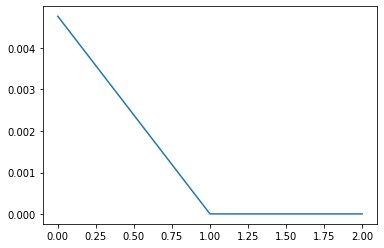

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
